In [1]:
import json
import nltk
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.distributions.normal as normal
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

from torch.nn.utils import clip_grad_norm_
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from nltk.tokenize import word_tokenize
from nltk.tokenize import MWETokenizer

from gensim.models import Word2Vec

In [2]:
torch.manual_seed(1)

In [3]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to C:\Users\Mihaela
[nltk_data]     Stoycheva\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### Load data

In [9]:
def load_data(filename, max_sentence_len):
    # the tokenizer splits <unk> so we use MWETokenizer to re-merge it
    data_original = []
    data_padded = []
    with open(filename) as f:
        for line in f:
            sentence, padded_sentence = tokenize_sentence(line, max_sentence_len)
            data_original.append(sentence)
            data_padded.append(padded_sentence)
    
    return data_original, data_padded

def tokenize_sentence(string, max_sentence_len):
    merger = MWETokenizer([('<', 'unk', '>')], separator = '') 
    sentence = word_tokenize(string.strip())       # tokenize sentence
    sentence = merger.tokenize(sentence)         # merge <unk>
    sentence = sentence[:max_sentence_len - 2]   # cut sentence at max_sentence_length
    sentence = ['<sos>'] + sentence + ['<eos>']  # add start and end-of-sentence tags

    # pad the rest of the sentence
    padded_sentence = sentence.copy()
    padded_sentence.extend(['<pad>']*(max_sentence_len - len(sentence))) 
    
    return sentence, padded_sentence

In [10]:
max_sentence_length = 50
train_data, train_data_padded = load_data("data/ptb.train.txt", max_sentence_length)
val_data, val_data_padded = load_data("data/ptb.valid.txt", max_sentence_length)
test_data, test_data_padded = load_data("data/ptb.test.txt", max_sentence_length)

### Create Word2Vec word embeddings

In [6]:
embedding_size = 500
num_epochs_to_train = 10

In [7]:
word2vec_model = Word2Vec(train_data, min_count=1, size=embedding_size, window=5)
word2vec_model.train(train_data, epochs=num_epochs_to_train, total_examples=word2vec_model.corpus_count)

(6666616, 9696000)

In [8]:
word2vec_model.wv.most_similar("stocks")
# word2vec_model.wv['credit']

[('issues', 0.7121069431304932),
 ('stock-index', 0.691788911819458),
 ('traders', 0.6770775318145752),
 ('index', 0.6716479063034058),
 ('nasdaq', 0.6556688547134399),
 ('investors', 0.6482288837432861),
 ('trades', 0.6452388763427734),
 ('futures', 0.6339257955551147),
 ('selling', 0.6047229170799255),
 ('stock-market', 0.6016063690185547)]

In [9]:
vocabulary_size = len(word2vec_model.wv.vocab)
print("size of the vocabulary:", vocabulary_size)

size of the vocabulary: 10005


### Split data into batches

In [10]:
def get_batches(data, data_padded, batch_size, pad_index, word2vec_model):
    inputs = []
    targets = []
    lengths = []
    for i in range(len(data) // batch_size):
        # take batch_size sentences from the data each time
        batch_sentences = data[i*batch_size:(i+1)*batch_size]
        batch_sentence_lens = [len(x) for x in batch_sentences]
        
        # sentences in a batch have to be sorted in decreasing order of length (for pack_padded_sentence)
        sorted_pairs = sorted(zip(batch_sentence_lens,batch_sentences), reverse=True)
        batch_sentences = [sentence for length, sentence in sorted_pairs]
        batch_sentence_lens = [length-1 for length, sentence in sorted_pairs]
        
        # each input and target is a (batch_size x max_sentence_len-1 x 1) matrix
        # initially filled with the index for padditng tag <pad>
        input_batch = np.ones((batch_size, len(data_padded[0])-1, 1)) * pad_index
        target_batch = np.ones((batch_size, len(data_padded[0])-1, 1)) * pad_index
        
        # for each sentence in the batch, fill the corresponding row in current_batch
        # with the indexed of the words in the sentence (except for <pad>)
        for j, sentence in enumerate(batch_sentences):
            word_indexes = np.array([word2vec_model.wv.vocab[word].index for word in sentence])
            input_batch[j,0:len(sentence)-1,0] = word_indexes[:-1]
            target_batch[j,0:len(sentence)-1,0] = word_indexes[1:]
        
        # make the matrices into torch tensors and append
#         inputs.append(torch.tensor(input_batch))
#         targets.append(torch.tensor(target_batch))
        inputs.append(input_batch)
        targets.append(target_batch)
        lengths.append(batch_sentence_lens)
    return inputs, targets, lengths

### Define RNNLM

In [11]:
class RNNLM(nn.Module):
    def __init__(self, vocabulary_size, embedding_size, hidden_size, num_layers, embedding_weights):
        super(RNNLM, self).__init__()
        self.embed = nn.Embedding.from_pretrained(embedding_weights)
        self.lstm = nn.LSTM(embedding_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocabulary_size)
        self.embedding_size = embedding_size
        
    def forward(self, x, hidden, x_lens, train=True):
        batch_size, max_len, _ = x.shape
        embedding_dim = self.embedding_size

        x = self.embed(torch.tensor(x, dtype=torch.long)).view(batch_size, max_len, embedding_dim)
        if train:
            x_lens = torch.tensor(x_lens, dtype=torch.long)
            x = pack_padded_sequence(x, x_lens, batch_first=True)

        out, hidden = self.lstm(x.float(), hidden) 
        
        if train:
            out, output_lens = pad_packed_sequence(out, batch_first=True, total_length=max_sentence_length-1)

        out = out.reshape(out.size(0)*out.size(1), out.size(2))
        out = self.linear(out)
        
        return out, hidden

### Train RNNLM

In [12]:
input_size = 100
output_size = 100
hidden_size = 50

In [13]:
batch_size = 20
use_first_k = 500
padding_index = vocabulary_size
train_batches, train_targets, train_sentence_lens = get_batches(train_data[:use_first_k], train_data_padded[:use_first_k], 
                                                                batch_size, padding_index, word2vec_model)

NameError: name 'vocabulary_size' is not defined

In [74]:
# make the word embeddings into a pythorch tensor
embedding_weights = word2vec_model.wv.vectors
embedding_weights = np.vstack((embedding_weights, np.zeros((1,embedding_size))))  # add zero vector for <pad>
embedding_weights = torch.tensor(embedding_weights)

In [12]:
learning_rate = 0.001
num_layers = 1
epochs = 10

In [76]:
model = RNNLM(vocabulary_size, embedding_size, hidden_size, num_layers, embedding_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [96]:
for epoch in range(epochs):
    hidden = (torch.zeros(num_layers, batch_size, hidden_size), torch.zeros(num_layers, batch_size, hidden_size))
    for i in range(len(train_batches)):
        x = train_batches[i]
        x_lens = train_sentence_lens[i]
        y = torch.tensor(train_targets[i].reshape(-1), dtype=torch.long)   
        h, c = hidden
        h = h.detach()
        c = c.detach()
        hidden = (h, c)
    
        outputs, hidden = model(x, hidden, x_lens)
        
        mask = (y < padding_index)
        loss = nn.CrossEntropyLoss()(outputs[mask], y[mask])

        model.zero_grad()
        loss.backward()
        clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

    if epoch % 1 == 0:
        print ('Epoch [{}/{}], Loss: {:.4f}, Perplexity: {:5.2f}'
               .format(epoch + 1, epochs, loss.item(), np.exp(loss.item())))

Epoch [1/10], Loss: 8.8069, Perplexity: 6680.21
Epoch [2/10], Loss: 7.1356, Perplexity: 1255.87


KeyboardInterrupt: 

In [97]:
# Predict
test_sentences = ["he could see"]
sentence, _ = tokenize_sentence(test_sentences[0], max_sentence_length)
sentence = sentence[:-1]
word_indexes = np.array([word2vec_model.wv.vocab[word].index for word in sentence]).reshape(1, len(sentence), 1)
print(word_indexes.shape)

hidden = (torch.zeros(1, 1, hidden_size), torch.zeros(1, 1, hidden_size))
h, c = hidden
h = h.detach()
c = c.detach()
hidden = (h, c)

outputs, hidden = model(word_indexes, hidden, x_lens, train=False)
softmax_outputs = F.softmax(outputs, dim=1).detach().numpy()
last_word = softmax_outputs[-1,:]
predicted_next_word_idx = np.random.choice(range(len(last_word)), p=last_word)
print("Argmax: ", word2vec_model.wv.index2word[np.argmax(last_word)])
print("Next word: ", word2vec_model.wv.index2word[predicted_next_word_idx])

(1, 4, 1)
Argmax:  the
Next word:  toseland


In [4]:
class Encoder(nn.Module):
    def __init__(self, hidden_size, num_layers, embedding_weights):
        super(Encoder, self).__init__()
        # parameters
        self.embedding_size = embedding_weights.shape[1]
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.batch_first = True
        
        #layers
        self.embed = nn.Embedding.from_pretrained(embedding_weights)
        self.lstm = nn.LSTM(self.embedding_size, self.hidden_size, self.num_layers, batch_first=self.batch_first)
        
    def forward(self, x, hidden, x_lens=None, train=True):
        batch_size, max_len, _ = x.shape
        
        x = torch.tensor(x, dtype=torch.long)  # make the input into a torch tensor
        x = self.embed(x).view(batch_size, max_len, self.embedding_size)

        if x_lens is not None and train:
            x_lens = torch.tensor(x_lens, dtype=torch.long)
            x = pack_padded_sequence(x, x_lens, batch_first=self.batch_first)
            
        output, hidden = self.lstm(x.float(), hidden) 

        if x_lens is not None and train:
            output, output_lens = pad_packed_sequence(output, batch_first=self.batch_first, 
                                                      total_length=max_sentence_length-1)
        
#         output = output.reshape(output.size(0)*output.size(1), output.size(2))
#         output = self.linear(output)
        
        return output, hidden
    
    def init_hidden(self, batch_size):
        h = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        c = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        return (h, c)

In [5]:
class Decoder(nn.Module):
    def __init__(self,hidden_size, num_layers, embedding_weights):
        super(Decoder, self).__init__()
        # parameters
        self.vocabulary_size = embedding_weights.shape[0]
        self.embedding_size = embedding_weights.shape[1]
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.batch_first = True
        
        # layers
        self.embed = nn.Embedding.from_pretrained(embedding_weights)
        self.lstm = nn.LSTM(self.embedding_size, self.hidden_size, self.num_layers, batch_first=self.batch_first)
        self.linear = nn.Linear(self.hidden_size, self.vocabulary_size)
#         self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x, hidden, x_lens=None, train=True):
        batch_size, max_len, _ = x.shape
        
        x = torch.tensor(x, dtype=torch.long)  # make the input into a torch tensor
        x = self.embed(x).view(batch_size, max_len, self.embedding_size)
        
        if x_lens is not None and train:
            x_lens = torch.tensor(x_lens, dtype=torch.long)
            x = pack_padded_sequence(x, x_lens, batch_first=self.batch_first)

        output, hidden = self.lstm(x.float(), hidden) 
        
        if x_lens is not None and train:
            output, output_lens = pad_packed_sequence(output, batch_first=self.batch_first, 
                                                      total_length=max_sentence_length-1)
        
        output = output.reshape(output.size(0)*output.size(1), output.size(2))
        output = self.linear(output)
        
        return output, hidden

In [6]:
class VAE(nn.Module):
    def __init__(self, hidden_dim, num_layers, embedding_weights, latent_dim):
        super(VAE, self).__init__()
        self.encoder = Encoder(hidden_size, num_layers, embedding_weights)
        self.decoder = Decoder(hidden_size, num_layers, embedding_weights)
        self.latent_dim = latent_dim
        self.hidden_dim = hidden_dim
        self.batch_first = True
        
        self.hidden_to_mean = nn.Linear(2 * self.hidden_dim * num_layers, self.latent_dim, self.batch_first)
        self.hidden_to_logvar = nn.Linear(2 * self.hidden_dim * num_layers, self.latent_dim, self.batch_first)
        self.latent_to_hidden = nn.Linear(latent_dim, 2 * self.hidden_dim * num_layers, self.batch_first)
        
    def reparametrize(self, mean, log_variance):
        eps = torch.randn_like(mean)
        return mean + eps * torch.exp(0.5 * log_variance)
        
    def encode(self, x, x_lens=None):
        batch_size, max_len, _ = x.shape
        hidden = self.encoder.init_hidden(batch_size)
        _, hidden = self.encoder.forward(x, hidden, x_lens)
        return hidden
        
    def decode(self, hidden, x, x_lens=None):
        outputs, _ = self.decoder.forward(x, hidden, x_lens)
        return outputs
    
    def forward(self, x, x_lens=None):
        hidden = self.encode(x, x_lens)
        hidden_concatenated = torch.cat((hidden[0], hidden[1]), 2)
        
        mean = self.hidden_to_mean(hidden_concatenated)
        
        log_variance = self.hidden_to_logvar(hidden_concatenated)
        z = self.reparametrize(mean, log_variance)
        hidden = self.latent_to_hidden(z)
        
        hidden = torch.split(hidden, self.hidden_dim, dim=2)
        outputs = self.decode(hidden, x, x_lens)
        return mean, log_variance, outputs

In [7]:
def loss_function(outputs, labels, mean, log_variance):
    BCE = nn.CrossEntropyLoss()(outputs, labels)
    KLD = -0.5 * torch.sum(1 + log_variance - mean.pow(2) - log_variance.exp())
    loss = BCE + KLD
    return loss
                           
vae = VAE(hidden_size, num_layers, embedding_weights, 10)
vae_optimizer = torch.optim.Adam(vae.parameters(), lr=learning_rate)

NameError: name 'hidden_size' is not defined

In [88]:
for epoch in range(epochs):
    for i in range(len(train_batches)):
        x = train_batches[i]
        x_lens = train_sentence_lens[i]
        y = torch.tensor(train_targets[i].reshape(-1), dtype=torch.long)
    
        mean, log_variance, outputs = vae(x, x_lens)
        
        mask = (y < padding_index)
        #loss = nn.CrossEntropyLoss()(outputs[mask], y[mask]) # TODO CHANGE THIS TO VAE LOSS
        loss = loss_function(outputs[mask], y[mask], mean, log_variance)

        vae.zero_grad()
        loss.backward()
        clip_grad_norm_(vae.parameters(), 0.5)
        vae_optimizer.step()

    if epoch % 1 == 0:
        print ('Epoch [{}/{}], Loss: {:.4f}, Perplexity: {:5.2f}'
               .format(epoch + 1, epochs, loss.item(), np.exp(loss.item())))

z torch.Size([1, 20, 10])
z torch.Size([1, 20, 10])
z torch.Size([1, 20, 10])
z torch.Size([1, 20, 10])
z torch.Size([1, 20, 10])
z torch.Size([1, 20, 10])
z torch.Size([1, 20, 10])
z torch.Size([1, 20, 10])
z torch.Size([1, 20, 10])
z torch.Size([1, 20, 10])
z torch.Size([1, 20, 10])
z torch.Size([1, 20, 10])
z torch.Size([1, 20, 10])
z torch.Size([1, 20, 10])
z torch.Size([1, 20, 10])
z torch.Size([1, 20, 10])
z torch.Size([1, 20, 10])
z torch.Size([1, 20, 10])
z torch.Size([1, 20, 10])
z torch.Size([1, 20, 10])


KeyboardInterrupt: 

In [ ]:
# Predict
test_sentences = ["he could see"]
sentence, _ = tokenize_sentence(test_sentences[0], max_sentence_length)
sentence = sentence[:-1]
word_indexes = np.array([word2vec_model.wv.vocab[word].index for word in sentence]).reshape(1, len(sentence), 1)
print(word_indexes.shape)

hidden = (torch.zeros(1, 1, hidden_size), torch.zeros(1, 1, hidden_size))
h, c = hidden
h = h.detach()
c = c.detach()
hidden = (h, c)

outputs, hidden = model(word_indexes, hidden, x_lens, train=False)
softmax_outputs = F.softmax(outputs, dim=1).detach().numpy()
last_word = softmax_outputs[-1,:]
predicted_next_word_idx = np.random.choice(range(len(last_word)), p=last_word)
print("Argmax: ", word2vec_model.wv.index2word[np.argmax(last_word)])
print("Next word: ", word2vec_model.wv.index2word[predicted_next_word_idx])

Synthetic data - posterior collapse demonstration

In [16]:
test_syn_data = np.loadtxt('./synthetic-data/synthetic_test.txt', dtype=int)
train_syn_data = np.loadtxt('./synthetic-data/synthetic_train.txt', dtype=int)

batch_size = 20
inputs = []
targets = []
random_indices = np.random.choice(train_syn_data.shape[0], 500)
tracked_inputs = []
tracked_targets = []
for random_index in random_indices:
    tracked_inputs.append(train_syn_data[random_index, :-1])
    tracked_targets.append(train_syn_data[random_index, 1:])
tracked_inputs = torch.tensor(tracked_inputs).unsqueeze(-1)
tracked_targets = torch.tensor(tracked_targets).unsqueeze(-1)

for i in range(len(train_syn_data) // batch_size):
    batch_sentences = train_syn_data[i * batch_size:(i+1) * batch_size]
    
    input_batch = np.ones((batch_size, train_syn_data.shape[1] - 1, 1)) 
    target_batch = np.ones((batch_size, train_syn_data.shape[1] - 1, 1)) 
    for j, sentence in enumerate(batch_sentences):
            input_batch[j,0:len(sentence)-1,0] = sentence[:-1]
            target_batch[j,0:len(sentence)-1,0] = sentence[1:]
    inputs.append(input_batch)
    targets.append(target_batch)

In [9]:
def log_sum_exp(value, dim=None, keepdim=False):
    """Numerically stable implementation of the operation
    value.exp().sum(dim, keepdim).log() - copied from repo, we should change it
    """
    if dim is not None:
        m, _ = torch.max(value, dim=dim, keepdim=True)
        value0 = value - m
        if keepdim is False:
            m = m.squeeze(dim)
        return m + torch.log(torch.sum(torch.exp(value0), dim=dim, keepdim=keepdim))
    else:
        m = torch.max(value)
        sum_exp = torch.sum(torch.exp(value - m))
        return m + torch.log(sum_exp)

    
def compute_true_posterior(batch, latent_grid, vae, target_batch): # latent_grid is K**2 x latent_dim, k = (zmax-zmin)/pace - what is that, I guess freq
    #all below should be of dimensions: batch x k^2
    log_true_posterior = compute_true_log_posterior(batch, latent_grid, vae, target_batch)
    true_posterior = log_true_posterior.exp()
    return true_posterior

def compute_true_log_posterior(batch, latent_grid, vae, target_batch):
    latent_grid = latent_grid.unsqueeze(0).expand(batch.shape[0], *latent_grid.size()).contiguous().permute(1, 0, 2)
    '''Compute the true joint.'''
    #log_true_joint should be of dimensions: batch_size, k^2
    log_true_joint = compute_true_joint(batch, latent_grid, vae, target_batch)
    
    '''Normalize by marginalizing z.'''
    log_true_posterior = log_true_joint - log_sum_exp(log_true_joint, dim=1, keepdim=True) # todo: check over which dim!
    #returns: batch_size, k^2
    return log_true_posterior

def compute_true_joint(batch, latent_grid, vae, target_batch):
    #latent_dim = latent_grid.size(2) # should be, check this
    batch_size, n_sample, latent_dim = latent_grid.size()
    seq_len = batch.shape[1]
    '''p(z)'''
    log_true_prior = torch.tensor(norm.logpdf(latent_grid.numpy()).sum(axis=-1), dtype=torch.float) #sum over -1 bcs..
    
    '''p(x | z)'''
    log_true_conditional = torch.zeros(latent_grid.size(0), latent_grid.size(1))
    print(latent_grid.shape)
    
    
    for i in range(latent_grid.size(0)):
        hidden = vae.latent_to_hidden(latent_grid[i]).unsqueeze(0)
        hidden = torch.split(hidden, vae.hidden_dim, dim=-1)
        outputs = vae.decode(hidden, batch)
        target_batch = torch.tensor(target_batch.reshape(-1), dtype=torch.long)
        log_true_conditional[i] = -nn.CrossEntropyLoss()(outputs, target_batch) # Take a negative of this? 
        print(log_true_conditional[i])
        
    '''p(x, z)'''
    log_true_joint = log_true_prior + log_true_conditional
    
    #returns batch_size, k^2
    return log_true_joint

def compute_true_posterior_mean(true_posterior, latent_grid): #dim of input: (k^2, latent_dim) for latent_grid
    #should be of dimensions: batch x latent_dim
    print(true_posterior.size(), latent_grid.size())
    return torch.mul(true_posterior.unsqueeze(2), latent_grid.unsqueeze(0)).sum(1) #is this ok?

def generate_grid(lower, upper, step, dim=2):
    line = torch.arange(lower, upper, step)
    total_points = line.size(0)
    if dim == 2:
        z1 = line.unsqueeze(1).repeat(1, total_points).view(-1)
        z2 = line.repeat(total_points)
        return torch.cat((z1.unsqueeze(-1), z2.unsqueeze(-1)), dim=-1)
    elif dim == 1:
        return line.unsqueeze(1)

In [13]:
vocab_size = 1000
hidden_size = 50
latent_size = 2
num_layers = 1
sequence_length = 10

x_lens = sequence_length*np.ones((batch_size, train_syn_data.shape[1] - 1))
embedding_weights = nn.Embedding(vocab_size, hidden_size).weight
vae = VAE(hidden_size, num_layers, embedding_weights, latent_size)
vae_optimizer = torch.optim.Adam(vae.parameters(), lr=learning_rate)

In [11]:
step = 1/10
latent_grid = generate_grid(-3, 3, step, latent_size)
true_posterior = compute_true_posterior(tracked_inputs, latent_grid, vae, tracked_targets)
true_mean = compute_true_posterior_mean(true_posterior.t(), latent_grid)

torch.Size([3600, 500, 2])


c:\program files\python35\lib\site-packages\ipykernel_launcher.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
c:\program files\python35\lib\site-packages\ipykernel_launcher.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


tensor([-6.9346, -6.9346, -6.9346, -6.9346, -6.9346, -6.9346, -6.9346, -6.9346,
        -6.9346, -6.9346, -6.9346, -6.9346, -6.9346, -6.9346, -6.9346, -6.9346,
        -6.9346, -6.9346, -6.9346, -6.9346, -6.9346, -6.9346, -6.9346, -6.9346,
        -6.9346, -6.9346, -6.9346, -6.9346, -6.9346, -6.9346, -6.9346, -6.9346,
        -6.9346, -6.9346, -6.9346, -6.9346, -6.9346, -6.9346, -6.9346, -6.9346,
        -6.9346, -6.9346, -6.9346, -6.9346, -6.9346, -6.9346, -6.9346, -6.9346,
        -6.9346, -6.9346, -6.9346, -6.9346, -6.9346, -6.9346, -6.9346, -6.9346,
        -6.9346, -6.9346, -6.9346, -6.9346, -6.9346, -6.9346, -6.9346, -6.9346,
        -6.9346, -6.9346, -6.9346, -6.9346, -6.9346, -6.9346, -6.9346, -6.9346,
        -6.9346, -6.9346, -6.9346, -6.9346, -6.9346, -6.9346, -6.9346, -6.9346,
        -6.9346, -6.9346, -6.9346, -6.9346, -6.9346, -6.9346, -6.9346, -6.9346,
        -6.9346, -6.9346, -6.9346, -6.9346, -6.9346, -6.9346, -6.9346, -6.9346,
        -6.9346, -6.9346, -6.9346, -6.93

        -6.9347, -6.9347, -6.9347, -6.9347], grad_fn=<SelectBackward>)
tensor([-6.9347, -6.9347, -6.9347, -6.9347, -6.9347, -6.9347, -6.9347, -6.9347,
        -6.9347, -6.9347, -6.9347, -6.9347, -6.9347, -6.9347, -6.9347, -6.9347,
        -6.9347, -6.9347, -6.9347, -6.9347, -6.9347, -6.9347, -6.9347, -6.9347,
        -6.9347, -6.9347, -6.9347, -6.9347, -6.9347, -6.9347, -6.9347, -6.9347,
        -6.9347, -6.9347, -6.9347, -6.9347, -6.9347, -6.9347, -6.9347, -6.9347,
        -6.9347, -6.9347, -6.9347, -6.9347, -6.9347, -6.9347, -6.9347, -6.9347,
        -6.9347, -6.9347, -6.9347, -6.9347, -6.9347, -6.9347, -6.9347, -6.9347,
        -6.9347, -6.9347, -6.9347, -6.9347, -6.9347, -6.9347, -6.9347, -6.9347,
        -6.9347, -6.9347, -6.9347, -6.9347, -6.9347, -6.9347, -6.9347, -6.9347,
        -6.9347, -6.9347, -6.9347, -6.9347, -6.9347, -6.9347, -6.9347, -6.9347,
        -6.9347, -6.9347, -6.9347, -6.9347, -6.9347, -6.9347, -6.9347, -6.9347,
        -6.9347, -6.9347, -6.9347, -6.9347, -6.93

        -6.9348, -6.9348, -6.9348, -6.9348], grad_fn=<SelectBackward>)
tensor([-6.9348, -6.9348, -6.9348, -6.9348, -6.9348, -6.9348, -6.9348, -6.9348,
        -6.9348, -6.9348, -6.9348, -6.9348, -6.9348, -6.9348, -6.9348, -6.9348,
        -6.9348, -6.9348, -6.9348, -6.9348, -6.9348, -6.9348, -6.9348, -6.9348,
        -6.9348, -6.9348, -6.9348, -6.9348, -6.9348, -6.9348, -6.9348, -6.9348,
        -6.9348, -6.9348, -6.9348, -6.9348, -6.9348, -6.9348, -6.9348, -6.9348,
        -6.9348, -6.9348, -6.9348, -6.9348, -6.9348, -6.9348, -6.9348, -6.9348,
        -6.9348, -6.9348, -6.9348, -6.9348, -6.9348, -6.9348, -6.9348, -6.9348,
        -6.9348, -6.9348, -6.9348, -6.9348, -6.9348, -6.9348, -6.9348, -6.9348,
        -6.9348, -6.9348, -6.9348, -6.9348, -6.9348, -6.9348, -6.9348, -6.9348,
        -6.9348, -6.9348, -6.9348, -6.9348, -6.9348, -6.9348, -6.9348, -6.9348,
        -6.9348, -6.9348, -6.9348, -6.9348, -6.9348, -6.9348, -6.9348, -6.9348,
        -6.9348, -6.9348, -6.9348, -6.9348, -6.93

tensor([-6.9350, -6.9350, -6.9350, -6.9350, -6.9350, -6.9350, -6.9350, -6.9350,
        -6.9350, -6.9350, -6.9350, -6.9350, -6.9350, -6.9350, -6.9350, -6.9350,
        -6.9350, -6.9350, -6.9350, -6.9350, -6.9350, -6.9350, -6.9350, -6.9350,
        -6.9350, -6.9350, -6.9350, -6.9350, -6.9350, -6.9350, -6.9350, -6.9350,
        -6.9350, -6.9350, -6.9350, -6.9350, -6.9350, -6.9350, -6.9350, -6.9350,
        -6.9350, -6.9350, -6.9350, -6.9350, -6.9350, -6.9350, -6.9350, -6.9350,
        -6.9350, -6.9350, -6.9350, -6.9350, -6.9350, -6.9350, -6.9350, -6.9350,
        -6.9350, -6.9350, -6.9350, -6.9350, -6.9350, -6.9350, -6.9350, -6.9350,
        -6.9350, -6.9350, -6.9350, -6.9350, -6.9350, -6.9350, -6.9350, -6.9350,
        -6.9350, -6.9350, -6.9350, -6.9350, -6.9350, -6.9350, -6.9350, -6.9350,
        -6.9350, -6.9350, -6.9350, -6.9350, -6.9350, -6.9350, -6.9350, -6.9350,
        -6.9350, -6.9350, -6.9350, -6.9350, -6.9350, -6.9350, -6.9350, -6.9350,
        -6.9350, -6.9350, -6.9350, -6.93

        -6.9352, -6.9352, -6.9352, -6.9352], grad_fn=<SelectBackward>)
tensor([-6.9353, -6.9353, -6.9353, -6.9353, -6.9353, -6.9353, -6.9353, -6.9353,
        -6.9353, -6.9353, -6.9353, -6.9353, -6.9353, -6.9353, -6.9353, -6.9353,
        -6.9353, -6.9353, -6.9353, -6.9353, -6.9353, -6.9353, -6.9353, -6.9353,
        -6.9353, -6.9353, -6.9353, -6.9353, -6.9353, -6.9353, -6.9353, -6.9353,
        -6.9353, -6.9353, -6.9353, -6.9353, -6.9353, -6.9353, -6.9353, -6.9353,
        -6.9353, -6.9353, -6.9353, -6.9353, -6.9353, -6.9353, -6.9353, -6.9353,
        -6.9353, -6.9353, -6.9353, -6.9353, -6.9353, -6.9353, -6.9353, -6.9353,
        -6.9353, -6.9353, -6.9353, -6.9353, -6.9353, -6.9353, -6.9353, -6.9353,
        -6.9353, -6.9353, -6.9353, -6.9353, -6.9353, -6.9353, -6.9353, -6.9353,
        -6.9353, -6.9353, -6.9353, -6.9353, -6.9353, -6.9353, -6.9353, -6.9353,
        -6.9353, -6.9353, -6.9353, -6.9353, -6.9353, -6.9353, -6.9353, -6.9353,
        -6.9353, -6.9353, -6.9353, -6.9353, -6.93

        -6.9354, -6.9354, -6.9354, -6.9354], grad_fn=<SelectBackward>)
tensor([-6.9356, -6.9356, -6.9356, -6.9356, -6.9356, -6.9356, -6.9356, -6.9356,
        -6.9356, -6.9356, -6.9356, -6.9356, -6.9356, -6.9356, -6.9356, -6.9356,
        -6.9356, -6.9356, -6.9356, -6.9356, -6.9356, -6.9356, -6.9356, -6.9356,
        -6.9356, -6.9356, -6.9356, -6.9356, -6.9356, -6.9356, -6.9356, -6.9356,
        -6.9356, -6.9356, -6.9356, -6.9356, -6.9356, -6.9356, -6.9356, -6.9356,
        -6.9356, -6.9356, -6.9356, -6.9356, -6.9356, -6.9356, -6.9356, -6.9356,
        -6.9356, -6.9356, -6.9356, -6.9356, -6.9356, -6.9356, -6.9356, -6.9356,
        -6.9356, -6.9356, -6.9356, -6.9356, -6.9356, -6.9356, -6.9356, -6.9356,
        -6.9356, -6.9356, -6.9356, -6.9356, -6.9356, -6.9356, -6.9356, -6.9356,
        -6.9356, -6.9356, -6.9356, -6.9356, -6.9356, -6.9356, -6.9356, -6.9356,
        -6.9356, -6.9356, -6.9356, -6.9356, -6.9356, -6.9356, -6.9356, -6.9356,
        -6.9356, -6.9356, -6.9356, -6.9356, -6.93

tensor([-6.9358, -6.9358, -6.9358, -6.9358, -6.9358, -6.9358, -6.9358, -6.9358,
        -6.9358, -6.9358, -6.9358, -6.9358, -6.9358, -6.9358, -6.9358, -6.9358,
        -6.9358, -6.9358, -6.9358, -6.9358, -6.9358, -6.9358, -6.9358, -6.9358,
        -6.9358, -6.9358, -6.9358, -6.9358, -6.9358, -6.9358, -6.9358, -6.9358,
        -6.9358, -6.9358, -6.9358, -6.9358, -6.9358, -6.9358, -6.9358, -6.9358,
        -6.9358, -6.9358, -6.9358, -6.9358, -6.9358, -6.9358, -6.9358, -6.9358,
        -6.9358, -6.9358, -6.9358, -6.9358, -6.9358, -6.9358, -6.9358, -6.9358,
        -6.9358, -6.9358, -6.9358, -6.9358, -6.9358, -6.9358, -6.9358, -6.9358,
        -6.9358, -6.9358, -6.9358, -6.9358, -6.9358, -6.9358, -6.9358, -6.9358,
        -6.9358, -6.9358, -6.9358, -6.9358, -6.9358, -6.9358, -6.9358, -6.9358,
        -6.9358, -6.9358, -6.9358, -6.9358, -6.9358, -6.9358, -6.9358, -6.9358,
        -6.9358, -6.9358, -6.9358, -6.9358, -6.9358, -6.9358, -6.9358, -6.9358,
        -6.9358, -6.9358, -6.9358, -6.93

tensor([-6.9361, -6.9361, -6.9361, -6.9361, -6.9361, -6.9361, -6.9361, -6.9361,
        -6.9361, -6.9361, -6.9361, -6.9361, -6.9361, -6.9361, -6.9361, -6.9361,
        -6.9361, -6.9361, -6.9361, -6.9361, -6.9361, -6.9361, -6.9361, -6.9361,
        -6.9361, -6.9361, -6.9361, -6.9361, -6.9361, -6.9361, -6.9361, -6.9361,
        -6.9361, -6.9361, -6.9361, -6.9361, -6.9361, -6.9361, -6.9361, -6.9361,
        -6.9361, -6.9361, -6.9361, -6.9361, -6.9361, -6.9361, -6.9361, -6.9361,
        -6.9361, -6.9361, -6.9361, -6.9361, -6.9361, -6.9361, -6.9361, -6.9361,
        -6.9361, -6.9361, -6.9361, -6.9361, -6.9361, -6.9361, -6.9361, -6.9361,
        -6.9361, -6.9361, -6.9361, -6.9361, -6.9361, -6.9361, -6.9361, -6.9361,
        -6.9361, -6.9361, -6.9361, -6.9361, -6.9361, -6.9361, -6.9361, -6.9361,
        -6.9361, -6.9361, -6.9361, -6.9361, -6.9361, -6.9361, -6.9361, -6.9361,
        -6.9361, -6.9361, -6.9361, -6.9361, -6.9361, -6.9361, -6.9361, -6.9361,
        -6.9361, -6.9361, -6.9361, -6.93

        -6.9365, -6.9365, -6.9365, -6.9365], grad_fn=<SelectBackward>)
tensor([-6.9366, -6.9366, -6.9366, -6.9366, -6.9366, -6.9366, -6.9366, -6.9366,
        -6.9366, -6.9366, -6.9366, -6.9366, -6.9366, -6.9366, -6.9366, -6.9366,
        -6.9366, -6.9366, -6.9366, -6.9366, -6.9366, -6.9366, -6.9366, -6.9366,
        -6.9366, -6.9366, -6.9366, -6.9366, -6.9366, -6.9366, -6.9366, -6.9366,
        -6.9366, -6.9366, -6.9366, -6.9366, -6.9366, -6.9366, -6.9366, -6.9366,
        -6.9366, -6.9366, -6.9366, -6.9366, -6.9366, -6.9366, -6.9366, -6.9366,
        -6.9366, -6.9366, -6.9366, -6.9366, -6.9366, -6.9366, -6.9366, -6.9366,
        -6.9366, -6.9366, -6.9366, -6.9366, -6.9366, -6.9366, -6.9366, -6.9366,
        -6.9366, -6.9366, -6.9366, -6.9366, -6.9366, -6.9366, -6.9366, -6.9366,
        -6.9366, -6.9366, -6.9366, -6.9366, -6.9366, -6.9366, -6.9366, -6.9366,
        -6.9366, -6.9366, -6.9366, -6.9366, -6.9366, -6.9366, -6.9366, -6.9366,
        -6.9366, -6.9366, -6.9366, -6.9366, -6.93

tensor([-6.9369, -6.9369, -6.9369, -6.9369, -6.9369, -6.9369, -6.9369, -6.9369,
        -6.9369, -6.9369, -6.9369, -6.9369, -6.9369, -6.9369, -6.9369, -6.9369,
        -6.9369, -6.9369, -6.9369, -6.9369, -6.9369, -6.9369, -6.9369, -6.9369,
        -6.9369, -6.9369, -6.9369, -6.9369, -6.9369, -6.9369, -6.9369, -6.9369,
        -6.9369, -6.9369, -6.9369, -6.9369, -6.9369, -6.9369, -6.9369, -6.9369,
        -6.9369, -6.9369, -6.9369, -6.9369, -6.9369, -6.9369, -6.9369, -6.9369,
        -6.9369, -6.9369, -6.9369, -6.9369, -6.9369, -6.9369, -6.9369, -6.9369,
        -6.9369, -6.9369, -6.9369, -6.9369, -6.9369, -6.9369, -6.9369, -6.9369,
        -6.9369, -6.9369, -6.9369, -6.9369, -6.9369, -6.9369, -6.9369, -6.9369,
        -6.9369, -6.9369, -6.9369, -6.9369, -6.9369, -6.9369, -6.9369, -6.9369,
        -6.9369, -6.9369, -6.9369, -6.9369, -6.9369, -6.9369, -6.9369, -6.9369,
        -6.9369, -6.9369, -6.9369, -6.9369, -6.9369, -6.9369, -6.9369, -6.9369,
        -6.9369, -6.9369, -6.9369, -6.93

tensor([-6.9374, -6.9374, -6.9374, -6.9374, -6.9374, -6.9374, -6.9374, -6.9374,
        -6.9374, -6.9374, -6.9374, -6.9374, -6.9374, -6.9374, -6.9374, -6.9374,
        -6.9374, -6.9374, -6.9374, -6.9374, -6.9374, -6.9374, -6.9374, -6.9374,
        -6.9374, -6.9374, -6.9374, -6.9374, -6.9374, -6.9374, -6.9374, -6.9374,
        -6.9374, -6.9374, -6.9374, -6.9374, -6.9374, -6.9374, -6.9374, -6.9374,
        -6.9374, -6.9374, -6.9374, -6.9374, -6.9374, -6.9374, -6.9374, -6.9374,
        -6.9374, -6.9374, -6.9374, -6.9374, -6.9374, -6.9374, -6.9374, -6.9374,
        -6.9374, -6.9374, -6.9374, -6.9374, -6.9374, -6.9374, -6.9374, -6.9374,
        -6.9374, -6.9374, -6.9374, -6.9374, -6.9374, -6.9374, -6.9374, -6.9374,
        -6.9374, -6.9374, -6.9374, -6.9374, -6.9374, -6.9374, -6.9374, -6.9374,
        -6.9374, -6.9374, -6.9374, -6.9374, -6.9374, -6.9374, -6.9374, -6.9374,
        -6.9374, -6.9374, -6.9374, -6.9374, -6.9374, -6.9374, -6.9374, -6.9374,
        -6.9374, -6.9374, -6.9374, -6.93

        -6.9379, -6.9379, -6.9379, -6.9379], grad_fn=<SelectBackward>)
tensor([-6.9381, -6.9381, -6.9381, -6.9381, -6.9381, -6.9381, -6.9381, -6.9381,
        -6.9381, -6.9381, -6.9381, -6.9381, -6.9381, -6.9381, -6.9381, -6.9381,
        -6.9381, -6.9381, -6.9381, -6.9381, -6.9381, -6.9381, -6.9381, -6.9381,
        -6.9381, -6.9381, -6.9381, -6.9381, -6.9381, -6.9381, -6.9381, -6.9381,
        -6.9381, -6.9381, -6.9381, -6.9381, -6.9381, -6.9381, -6.9381, -6.9381,
        -6.9381, -6.9381, -6.9381, -6.9381, -6.9381, -6.9381, -6.9381, -6.9381,
        -6.9381, -6.9381, -6.9381, -6.9381, -6.9381, -6.9381, -6.9381, -6.9381,
        -6.9381, -6.9381, -6.9381, -6.9381, -6.9381, -6.9381, -6.9381, -6.9381,
        -6.9381, -6.9381, -6.9381, -6.9381, -6.9381, -6.9381, -6.9381, -6.9381,
        -6.9381, -6.9381, -6.9381, -6.9381, -6.9381, -6.9381, -6.9381, -6.9381,
        -6.9381, -6.9381, -6.9381, -6.9381, -6.9381, -6.9381, -6.9381, -6.9381,
        -6.9381, -6.9381, -6.9381, -6.9381, -6.93

tensor([-6.9385, -6.9385, -6.9385, -6.9385, -6.9385, -6.9385, -6.9385, -6.9385,
        -6.9385, -6.9385, -6.9385, -6.9385, -6.9385, -6.9385, -6.9385, -6.9385,
        -6.9385, -6.9385, -6.9385, -6.9385, -6.9385, -6.9385, -6.9385, -6.9385,
        -6.9385, -6.9385, -6.9385, -6.9385, -6.9385, -6.9385, -6.9385, -6.9385,
        -6.9385, -6.9385, -6.9385, -6.9385, -6.9385, -6.9385, -6.9385, -6.9385,
        -6.9385, -6.9385, -6.9385, -6.9385, -6.9385, -6.9385, -6.9385, -6.9385,
        -6.9385, -6.9385, -6.9385, -6.9385, -6.9385, -6.9385, -6.9385, -6.9385,
        -6.9385, -6.9385, -6.9385, -6.9385, -6.9385, -6.9385, -6.9385, -6.9385,
        -6.9385, -6.9385, -6.9385, -6.9385, -6.9385, -6.9385, -6.9385, -6.9385,
        -6.9385, -6.9385, -6.9385, -6.9385, -6.9385, -6.9385, -6.9385, -6.9385,
        -6.9385, -6.9385, -6.9385, -6.9385, -6.9385, -6.9385, -6.9385, -6.9385,
        -6.9385, -6.9385, -6.9385, -6.9385, -6.9385, -6.9385, -6.9385, -6.9385,
        -6.9385, -6.9385, -6.9385, -6.93

tensor([-6.9390, -6.9390, -6.9390, -6.9390, -6.9390, -6.9390, -6.9390, -6.9390,
        -6.9390, -6.9390, -6.9390, -6.9390, -6.9390, -6.9390, -6.9390, -6.9390,
        -6.9390, -6.9390, -6.9390, -6.9390, -6.9390, -6.9390, -6.9390, -6.9390,
        -6.9390, -6.9390, -6.9390, -6.9390, -6.9390, -6.9390, -6.9390, -6.9390,
        -6.9390, -6.9390, -6.9390, -6.9390, -6.9390, -6.9390, -6.9390, -6.9390,
        -6.9390, -6.9390, -6.9390, -6.9390, -6.9390, -6.9390, -6.9390, -6.9390,
        -6.9390, -6.9390, -6.9390, -6.9390, -6.9390, -6.9390, -6.9390, -6.9390,
        -6.9390, -6.9390, -6.9390, -6.9390, -6.9390, -6.9390, -6.9390, -6.9390,
        -6.9390, -6.9390, -6.9390, -6.9390, -6.9390, -6.9390, -6.9390, -6.9390,
        -6.9390, -6.9390, -6.9390, -6.9390, -6.9390, -6.9390, -6.9390, -6.9390,
        -6.9390, -6.9390, -6.9390, -6.9390, -6.9390, -6.9390, -6.9390, -6.9390,
        -6.9390, -6.9390, -6.9390, -6.9390, -6.9390, -6.9390, -6.9390, -6.9390,
        -6.9390, -6.9390, -6.9390, -6.93

tensor([-6.9393, -6.9393, -6.9393, -6.9393, -6.9393, -6.9393, -6.9393, -6.9393,
        -6.9393, -6.9393, -6.9393, -6.9393, -6.9393, -6.9393, -6.9393, -6.9393,
        -6.9393, -6.9393, -6.9393, -6.9393, -6.9393, -6.9393, -6.9393, -6.9393,
        -6.9393, -6.9393, -6.9393, -6.9393, -6.9393, -6.9393, -6.9393, -6.9393,
        -6.9393, -6.9393, -6.9393, -6.9393, -6.9393, -6.9393, -6.9393, -6.9393,
        -6.9393, -6.9393, -6.9393, -6.9393, -6.9393, -6.9393, -6.9393, -6.9393,
        -6.9393, -6.9393, -6.9393, -6.9393, -6.9393, -6.9393, -6.9393, -6.9393,
        -6.9393, -6.9393, -6.9393, -6.9393, -6.9393, -6.9393, -6.9393, -6.9393,
        -6.9393, -6.9393, -6.9393, -6.9393, -6.9393, -6.9393, -6.9393, -6.9393,
        -6.9393, -6.9393, -6.9393, -6.9393, -6.9393, -6.9393, -6.9393, -6.9393,
        -6.9393, -6.9393, -6.9393, -6.9393, -6.9393, -6.9393, -6.9393, -6.9393,
        -6.9393, -6.9393, -6.9393, -6.9393, -6.9393, -6.9393, -6.9393, -6.9393,
        -6.9393, -6.9393, -6.9393, -6.93

tensor([-6.9399, -6.9399, -6.9399, -6.9399, -6.9399, -6.9399, -6.9399, -6.9399,
        -6.9399, -6.9399, -6.9399, -6.9399, -6.9399, -6.9399, -6.9399, -6.9399,
        -6.9399, -6.9399, -6.9399, -6.9399, -6.9399, -6.9399, -6.9399, -6.9399,
        -6.9399, -6.9399, -6.9399, -6.9399, -6.9399, -6.9399, -6.9399, -6.9399,
        -6.9399, -6.9399, -6.9399, -6.9399, -6.9399, -6.9399, -6.9399, -6.9399,
        -6.9399, -6.9399, -6.9399, -6.9399, -6.9399, -6.9399, -6.9399, -6.9399,
        -6.9399, -6.9399, -6.9399, -6.9399, -6.9399, -6.9399, -6.9399, -6.9399,
        -6.9399, -6.9399, -6.9399, -6.9399, -6.9399, -6.9399, -6.9399, -6.9399,
        -6.9399, -6.9399, -6.9399, -6.9399, -6.9399, -6.9399, -6.9399, -6.9399,
        -6.9399, -6.9399, -6.9399, -6.9399, -6.9399, -6.9399, -6.9399, -6.9399,
        -6.9399, -6.9399, -6.9399, -6.9399, -6.9399, -6.9399, -6.9399, -6.9399,
        -6.9399, -6.9399, -6.9399, -6.9399, -6.9399, -6.9399, -6.9399, -6.9399,
        -6.9399, -6.9399, -6.9399, -6.93

tensor([-6.9403, -6.9403, -6.9403, -6.9403, -6.9403, -6.9403, -6.9403, -6.9403,
        -6.9403, -6.9403, -6.9403, -6.9403, -6.9403, -6.9403, -6.9403, -6.9403,
        -6.9403, -6.9403, -6.9403, -6.9403, -6.9403, -6.9403, -6.9403, -6.9403,
        -6.9403, -6.9403, -6.9403, -6.9403, -6.9403, -6.9403, -6.9403, -6.9403,
        -6.9403, -6.9403, -6.9403, -6.9403, -6.9403, -6.9403, -6.9403, -6.9403,
        -6.9403, -6.9403, -6.9403, -6.9403, -6.9403, -6.9403, -6.9403, -6.9403,
        -6.9403, -6.9403, -6.9403, -6.9403, -6.9403, -6.9403, -6.9403, -6.9403,
        -6.9403, -6.9403, -6.9403, -6.9403, -6.9403, -6.9403, -6.9403, -6.9403,
        -6.9403, -6.9403, -6.9403, -6.9403, -6.9403, -6.9403, -6.9403, -6.9403,
        -6.9403, -6.9403, -6.9403, -6.9403, -6.9403, -6.9403, -6.9403, -6.9403,
        -6.9403, -6.9403, -6.9403, -6.9403, -6.9403, -6.9403, -6.9403, -6.9403,
        -6.9403, -6.9403, -6.9403, -6.9403, -6.9403, -6.9403, -6.9403, -6.9403,
        -6.9403, -6.9403, -6.9403, -6.94

tensor([-6.9407, -6.9407, -6.9407, -6.9407, -6.9407, -6.9407, -6.9407, -6.9407,
        -6.9407, -6.9407, -6.9407, -6.9407, -6.9407, -6.9407, -6.9407, -6.9407,
        -6.9407, -6.9407, -6.9407, -6.9407, -6.9407, -6.9407, -6.9407, -6.9407,
        -6.9407, -6.9407, -6.9407, -6.9407, -6.9407, -6.9407, -6.9407, -6.9407,
        -6.9407, -6.9407, -6.9407, -6.9407, -6.9407, -6.9407, -6.9407, -6.9407,
        -6.9407, -6.9407, -6.9407, -6.9407, -6.9407, -6.9407, -6.9407, -6.9407,
        -6.9407, -6.9407, -6.9407, -6.9407, -6.9407, -6.9407, -6.9407, -6.9407,
        -6.9407, -6.9407, -6.9407, -6.9407, -6.9407, -6.9407, -6.9407, -6.9407,
        -6.9407, -6.9407, -6.9407, -6.9407, -6.9407, -6.9407, -6.9407, -6.9407,
        -6.9407, -6.9407, -6.9407, -6.9407, -6.9407, -6.9407, -6.9407, -6.9407,
        -6.9407, -6.9407, -6.9407, -6.9407, -6.9407, -6.9407, -6.9407, -6.9407,
        -6.9407, -6.9407, -6.9407, -6.9407, -6.9407, -6.9407, -6.9407, -6.9407,
        -6.9407, -6.9407, -6.9407, -6.94

tensor([-6.9411, -6.9411, -6.9411, -6.9411, -6.9411, -6.9411, -6.9411, -6.9411,
        -6.9411, -6.9411, -6.9411, -6.9411, -6.9411, -6.9411, -6.9411, -6.9411,
        -6.9411, -6.9411, -6.9411, -6.9411, -6.9411, -6.9411, -6.9411, -6.9411,
        -6.9411, -6.9411, -6.9411, -6.9411, -6.9411, -6.9411, -6.9411, -6.9411,
        -6.9411, -6.9411, -6.9411, -6.9411, -6.9411, -6.9411, -6.9411, -6.9411,
        -6.9411, -6.9411, -6.9411, -6.9411, -6.9411, -6.9411, -6.9411, -6.9411,
        -6.9411, -6.9411, -6.9411, -6.9411, -6.9411, -6.9411, -6.9411, -6.9411,
        -6.9411, -6.9411, -6.9411, -6.9411, -6.9411, -6.9411, -6.9411, -6.9411,
        -6.9411, -6.9411, -6.9411, -6.9411, -6.9411, -6.9411, -6.9411, -6.9411,
        -6.9411, -6.9411, -6.9411, -6.9411, -6.9411, -6.9411, -6.9411, -6.9411,
        -6.9411, -6.9411, -6.9411, -6.9411, -6.9411, -6.9411, -6.9411, -6.9411,
        -6.9411, -6.9411, -6.9411, -6.9411, -6.9411, -6.9411, -6.9411, -6.9411,
        -6.9411, -6.9411, -6.9411, -6.94

        -6.9412, -6.9412, -6.9412, -6.9412], grad_fn=<SelectBackward>)
tensor([-6.9413, -6.9413, -6.9413, -6.9413, -6.9413, -6.9413, -6.9413, -6.9413,
        -6.9413, -6.9413, -6.9413, -6.9413, -6.9413, -6.9413, -6.9413, -6.9413,
        -6.9413, -6.9413, -6.9413, -6.9413, -6.9413, -6.9413, -6.9413, -6.9413,
        -6.9413, -6.9413, -6.9413, -6.9413, -6.9413, -6.9413, -6.9413, -6.9413,
        -6.9413, -6.9413, -6.9413, -6.9413, -6.9413, -6.9413, -6.9413, -6.9413,
        -6.9413, -6.9413, -6.9413, -6.9413, -6.9413, -6.9413, -6.9413, -6.9413,
        -6.9413, -6.9413, -6.9413, -6.9413, -6.9413, -6.9413, -6.9413, -6.9413,
        -6.9413, -6.9413, -6.9413, -6.9413, -6.9413, -6.9413, -6.9413, -6.9413,
        -6.9413, -6.9413, -6.9413, -6.9413, -6.9413, -6.9413, -6.9413, -6.9413,
        -6.9413, -6.9413, -6.9413, -6.9413, -6.9413, -6.9413, -6.9413, -6.9413,
        -6.9413, -6.9413, -6.9413, -6.9413, -6.9413, -6.9413, -6.9413, -6.9413,
        -6.9413, -6.9413, -6.9413, -6.9413, -6.94

        -6.9415, -6.9415, -6.9415, -6.9415], grad_fn=<SelectBackward>)
tensor([-6.9345, -6.9345, -6.9345, -6.9345, -6.9345, -6.9345, -6.9345, -6.9345,
        -6.9345, -6.9345, -6.9345, -6.9345, -6.9345, -6.9345, -6.9345, -6.9345,
        -6.9345, -6.9345, -6.9345, -6.9345, -6.9345, -6.9345, -6.9345, -6.9345,
        -6.9345, -6.9345, -6.9345, -6.9345, -6.9345, -6.9345, -6.9345, -6.9345,
        -6.9345, -6.9345, -6.9345, -6.9345, -6.9345, -6.9345, -6.9345, -6.9345,
        -6.9345, -6.9345, -6.9345, -6.9345, -6.9345, -6.9345, -6.9345, -6.9345,
        -6.9345, -6.9345, -6.9345, -6.9345, -6.9345, -6.9345, -6.9345, -6.9345,
        -6.9345, -6.9345, -6.9345, -6.9345, -6.9345, -6.9345, -6.9345, -6.9345,
        -6.9345, -6.9345, -6.9345, -6.9345, -6.9345, -6.9345, -6.9345, -6.9345,
        -6.9345, -6.9345, -6.9345, -6.9345, -6.9345, -6.9345, -6.9345, -6.9345,
        -6.9345, -6.9345, -6.9345, -6.9345, -6.9345, -6.9345, -6.9345, -6.9345,
        -6.9345, -6.9345, -6.9345, -6.9345, -6.93

        -6.9345, -6.9345, -6.9345, -6.9345], grad_fn=<SelectBackward>)
tensor([-6.9345, -6.9345, -6.9345, -6.9345, -6.9345, -6.9345, -6.9345, -6.9345,
        -6.9345, -6.9345, -6.9345, -6.9345, -6.9345, -6.9345, -6.9345, -6.9345,
        -6.9345, -6.9345, -6.9345, -6.9345, -6.9345, -6.9345, -6.9345, -6.9345,
        -6.9345, -6.9345, -6.9345, -6.9345, -6.9345, -6.9345, -6.9345, -6.9345,
        -6.9345, -6.9345, -6.9345, -6.9345, -6.9345, -6.9345, -6.9345, -6.9345,
        -6.9345, -6.9345, -6.9345, -6.9345, -6.9345, -6.9345, -6.9345, -6.9345,
        -6.9345, -6.9345, -6.9345, -6.9345, -6.9345, -6.9345, -6.9345, -6.9345,
        -6.9345, -6.9345, -6.9345, -6.9345, -6.9345, -6.9345, -6.9345, -6.9345,
        -6.9345, -6.9345, -6.9345, -6.9345, -6.9345, -6.9345, -6.9345, -6.9345,
        -6.9345, -6.9345, -6.9345, -6.9345, -6.9345, -6.9345, -6.9345, -6.9345,
        -6.9345, -6.9345, -6.9345, -6.9345, -6.9345, -6.9345, -6.9345, -6.9345,
        -6.9345, -6.9345, -6.9345, -6.9345, -6.93

tensor([-6.9346, -6.9346, -6.9346, -6.9346, -6.9346, -6.9346, -6.9346, -6.9346,
        -6.9346, -6.9346, -6.9346, -6.9346, -6.9346, -6.9346, -6.9346, -6.9346,
        -6.9346, -6.9346, -6.9346, -6.9346, -6.9346, -6.9346, -6.9346, -6.9346,
        -6.9346, -6.9346, -6.9346, -6.9346, -6.9346, -6.9346, -6.9346, -6.9346,
        -6.9346, -6.9346, -6.9346, -6.9346, -6.9346, -6.9346, -6.9346, -6.9346,
        -6.9346, -6.9346, -6.9346, -6.9346, -6.9346, -6.9346, -6.9346, -6.9346,
        -6.9346, -6.9346, -6.9346, -6.9346, -6.9346, -6.9346, -6.9346, -6.9346,
        -6.9346, -6.9346, -6.9346, -6.9346, -6.9346, -6.9346, -6.9346, -6.9346,
        -6.9346, -6.9346, -6.9346, -6.9346, -6.9346, -6.9346, -6.9346, -6.9346,
        -6.9346, -6.9346, -6.9346, -6.9346, -6.9346, -6.9346, -6.9346, -6.9346,
        -6.9346, -6.9346, -6.9346, -6.9346, -6.9346, -6.9346, -6.9346, -6.9346,
        -6.9346, -6.9346, -6.9346, -6.9346, -6.9346, -6.9346, -6.9346, -6.9346,
        -6.9346, -6.9346, -6.9346, -6.93

tensor([-6.9347, -6.9347, -6.9347, -6.9347, -6.9347, -6.9347, -6.9347, -6.9347,
        -6.9347, -6.9347, -6.9347, -6.9347, -6.9347, -6.9347, -6.9347, -6.9347,
        -6.9347, -6.9347, -6.9347, -6.9347, -6.9347, -6.9347, -6.9347, -6.9347,
        -6.9347, -6.9347, -6.9347, -6.9347, -6.9347, -6.9347, -6.9347, -6.9347,
        -6.9347, -6.9347, -6.9347, -6.9347, -6.9347, -6.9347, -6.9347, -6.9347,
        -6.9347, -6.9347, -6.9347, -6.9347, -6.9347, -6.9347, -6.9347, -6.9347,
        -6.9347, -6.9347, -6.9347, -6.9347, -6.9347, -6.9347, -6.9347, -6.9347,
        -6.9347, -6.9347, -6.9347, -6.9347, -6.9347, -6.9347, -6.9347, -6.9347,
        -6.9347, -6.9347, -6.9347, -6.9347, -6.9347, -6.9347, -6.9347, -6.9347,
        -6.9347, -6.9347, -6.9347, -6.9347, -6.9347, -6.9347, -6.9347, -6.9347,
        -6.9347, -6.9347, -6.9347, -6.9347, -6.9347, -6.9347, -6.9347, -6.9347,
        -6.9347, -6.9347, -6.9347, -6.9347, -6.9347, -6.9347, -6.9347, -6.9347,
        -6.9347, -6.9347, -6.9347, -6.93

tensor([-6.9348, -6.9348, -6.9348, -6.9348, -6.9348, -6.9348, -6.9348, -6.9348,
        -6.9348, -6.9348, -6.9348, -6.9348, -6.9348, -6.9348, -6.9348, -6.9348,
        -6.9348, -6.9348, -6.9348, -6.9348, -6.9348, -6.9348, -6.9348, -6.9348,
        -6.9348, -6.9348, -6.9348, -6.9348, -6.9348, -6.9348, -6.9348, -6.9348,
        -6.9348, -6.9348, -6.9348, -6.9348, -6.9348, -6.9348, -6.9348, -6.9348,
        -6.9348, -6.9348, -6.9348, -6.9348, -6.9348, -6.9348, -6.9348, -6.9348,
        -6.9348, -6.9348, -6.9348, -6.9348, -6.9348, -6.9348, -6.9348, -6.9348,
        -6.9348, -6.9348, -6.9348, -6.9348, -6.9348, -6.9348, -6.9348, -6.9348,
        -6.9348, -6.9348, -6.9348, -6.9348, -6.9348, -6.9348, -6.9348, -6.9348,
        -6.9348, -6.9348, -6.9348, -6.9348, -6.9348, -6.9348, -6.9348, -6.9348,
        -6.9348, -6.9348, -6.9348, -6.9348, -6.9348, -6.9348, -6.9348, -6.9348,
        -6.9348, -6.9348, -6.9348, -6.9348, -6.9348, -6.9348, -6.9348, -6.9348,
        -6.9348, -6.9348, -6.9348, -6.93

        -6.9350, -6.9350, -6.9350, -6.9350], grad_fn=<SelectBackward>)
tensor([-6.9351, -6.9351, -6.9351, -6.9351, -6.9351, -6.9351, -6.9351, -6.9351,
        -6.9351, -6.9351, -6.9351, -6.9351, -6.9351, -6.9351, -6.9351, -6.9351,
        -6.9351, -6.9351, -6.9351, -6.9351, -6.9351, -6.9351, -6.9351, -6.9351,
        -6.9351, -6.9351, -6.9351, -6.9351, -6.9351, -6.9351, -6.9351, -6.9351,
        -6.9351, -6.9351, -6.9351, -6.9351, -6.9351, -6.9351, -6.9351, -6.9351,
        -6.9351, -6.9351, -6.9351, -6.9351, -6.9351, -6.9351, -6.9351, -6.9351,
        -6.9351, -6.9351, -6.9351, -6.9351, -6.9351, -6.9351, -6.9351, -6.9351,
        -6.9351, -6.9351, -6.9351, -6.9351, -6.9351, -6.9351, -6.9351, -6.9351,
        -6.9351, -6.9351, -6.9351, -6.9351, -6.9351, -6.9351, -6.9351, -6.9351,
        -6.9351, -6.9351, -6.9351, -6.9351, -6.9351, -6.9351, -6.9351, -6.9351,
        -6.9351, -6.9351, -6.9351, -6.9351, -6.9351, -6.9351, -6.9351, -6.9351,
        -6.9351, -6.9351, -6.9351, -6.9351, -6.93

tensor([-6.9353, -6.9353, -6.9353, -6.9353, -6.9353, -6.9353, -6.9353, -6.9353,
        -6.9353, -6.9353, -6.9353, -6.9353, -6.9353, -6.9353, -6.9353, -6.9353,
        -6.9353, -6.9353, -6.9353, -6.9353, -6.9353, -6.9353, -6.9353, -6.9353,
        -6.9353, -6.9353, -6.9353, -6.9353, -6.9353, -6.9353, -6.9353, -6.9353,
        -6.9353, -6.9353, -6.9353, -6.9353, -6.9353, -6.9353, -6.9353, -6.9353,
        -6.9353, -6.9353, -6.9353, -6.9353, -6.9353, -6.9353, -6.9353, -6.9353,
        -6.9353, -6.9353, -6.9353, -6.9353, -6.9353, -6.9353, -6.9353, -6.9353,
        -6.9353, -6.9353, -6.9353, -6.9353, -6.9353, -6.9353, -6.9353, -6.9353,
        -6.9353, -6.9353, -6.9353, -6.9353, -6.9353, -6.9353, -6.9353, -6.9353,
        -6.9353, -6.9353, -6.9353, -6.9353, -6.9353, -6.9353, -6.9353, -6.9353,
        -6.9353, -6.9353, -6.9353, -6.9353, -6.9353, -6.9353, -6.9353, -6.9353,
        -6.9353, -6.9353, -6.9353, -6.9353, -6.9353, -6.9353, -6.9353, -6.9353,
        -6.9353, -6.9353, -6.9353, -6.93

tensor([-6.9356, -6.9356, -6.9356, -6.9356, -6.9356, -6.9356, -6.9356, -6.9356,
        -6.9356, -6.9356, -6.9356, -6.9356, -6.9356, -6.9356, -6.9356, -6.9356,
        -6.9356, -6.9356, -6.9356, -6.9356, -6.9356, -6.9356, -6.9356, -6.9356,
        -6.9356, -6.9356, -6.9356, -6.9356, -6.9356, -6.9356, -6.9356, -6.9356,
        -6.9356, -6.9356, -6.9356, -6.9356, -6.9356, -6.9356, -6.9356, -6.9356,
        -6.9356, -6.9356, -6.9356, -6.9356, -6.9356, -6.9356, -6.9356, -6.9356,
        -6.9356, -6.9356, -6.9356, -6.9356, -6.9356, -6.9356, -6.9356, -6.9356,
        -6.9356, -6.9356, -6.9356, -6.9356, -6.9356, -6.9356, -6.9356, -6.9356,
        -6.9356, -6.9356, -6.9356, -6.9356, -6.9356, -6.9356, -6.9356, -6.9356,
        -6.9356, -6.9356, -6.9356, -6.9356, -6.9356, -6.9356, -6.9356, -6.9356,
        -6.9356, -6.9356, -6.9356, -6.9356, -6.9356, -6.9356, -6.9356, -6.9356,
        -6.9356, -6.9356, -6.9356, -6.9356, -6.9356, -6.9356, -6.9356, -6.9356,
        -6.9356, -6.9356, -6.9356, -6.93

tensor([-6.9359, -6.9359, -6.9359, -6.9359, -6.9359, -6.9359, -6.9359, -6.9359,
        -6.9359, -6.9359, -6.9359, -6.9359, -6.9359, -6.9359, -6.9359, -6.9359,
        -6.9359, -6.9359, -6.9359, -6.9359, -6.9359, -6.9359, -6.9359, -6.9359,
        -6.9359, -6.9359, -6.9359, -6.9359, -6.9359, -6.9359, -6.9359, -6.9359,
        -6.9359, -6.9359, -6.9359, -6.9359, -6.9359, -6.9359, -6.9359, -6.9359,
        -6.9359, -6.9359, -6.9359, -6.9359, -6.9359, -6.9359, -6.9359, -6.9359,
        -6.9359, -6.9359, -6.9359, -6.9359, -6.9359, -6.9359, -6.9359, -6.9359,
        -6.9359, -6.9359, -6.9359, -6.9359, -6.9359, -6.9359, -6.9359, -6.9359,
        -6.9359, -6.9359, -6.9359, -6.9359, -6.9359, -6.9359, -6.9359, -6.9359,
        -6.9359, -6.9359, -6.9359, -6.9359, -6.9359, -6.9359, -6.9359, -6.9359,
        -6.9359, -6.9359, -6.9359, -6.9359, -6.9359, -6.9359, -6.9359, -6.9359,
        -6.9359, -6.9359, -6.9359, -6.9359, -6.9359, -6.9359, -6.9359, -6.9359,
        -6.9359, -6.9359, -6.9359, -6.93

tensor([-6.9362, -6.9362, -6.9362, -6.9362, -6.9362, -6.9362, -6.9362, -6.9362,
        -6.9362, -6.9362, -6.9362, -6.9362, -6.9362, -6.9362, -6.9362, -6.9362,
        -6.9362, -6.9362, -6.9362, -6.9362, -6.9362, -6.9362, -6.9362, -6.9362,
        -6.9362, -6.9362, -6.9362, -6.9362, -6.9362, -6.9362, -6.9362, -6.9362,
        -6.9362, -6.9362, -6.9362, -6.9362, -6.9362, -6.9362, -6.9362, -6.9362,
        -6.9362, -6.9362, -6.9362, -6.9362, -6.9362, -6.9362, -6.9362, -6.9362,
        -6.9362, -6.9362, -6.9362, -6.9362, -6.9362, -6.9362, -6.9362, -6.9362,
        -6.9362, -6.9362, -6.9362, -6.9362, -6.9362, -6.9362, -6.9362, -6.9362,
        -6.9362, -6.9362, -6.9362, -6.9362, -6.9362, -6.9362, -6.9362, -6.9362,
        -6.9362, -6.9362, -6.9362, -6.9362, -6.9362, -6.9362, -6.9362, -6.9362,
        -6.9362, -6.9362, -6.9362, -6.9362, -6.9362, -6.9362, -6.9362, -6.9362,
        -6.9362, -6.9362, -6.9362, -6.9362, -6.9362, -6.9362, -6.9362, -6.9362,
        -6.9362, -6.9362, -6.9362, -6.93

tensor([-6.9364, -6.9364, -6.9364, -6.9364, -6.9364, -6.9364, -6.9364, -6.9364,
        -6.9364, -6.9364, -6.9364, -6.9364, -6.9364, -6.9364, -6.9364, -6.9364,
        -6.9364, -6.9364, -6.9364, -6.9364, -6.9364, -6.9364, -6.9364, -6.9364,
        -6.9364, -6.9364, -6.9364, -6.9364, -6.9364, -6.9364, -6.9364, -6.9364,
        -6.9364, -6.9364, -6.9364, -6.9364, -6.9364, -6.9364, -6.9364, -6.9364,
        -6.9364, -6.9364, -6.9364, -6.9364, -6.9364, -6.9364, -6.9364, -6.9364,
        -6.9364, -6.9364, -6.9364, -6.9364, -6.9364, -6.9364, -6.9364, -6.9364,
        -6.9364, -6.9364, -6.9364, -6.9364, -6.9364, -6.9364, -6.9364, -6.9364,
        -6.9364, -6.9364, -6.9364, -6.9364, -6.9364, -6.9364, -6.9364, -6.9364,
        -6.9364, -6.9364, -6.9364, -6.9364, -6.9364, -6.9364, -6.9364, -6.9364,
        -6.9364, -6.9364, -6.9364, -6.9364, -6.9364, -6.9364, -6.9364, -6.9364,
        -6.9364, -6.9364, -6.9364, -6.9364, -6.9364, -6.9364, -6.9364, -6.9364,
        -6.9364, -6.9364, -6.9364, -6.93

tensor([-6.9367, -6.9367, -6.9367, -6.9367, -6.9367, -6.9367, -6.9367, -6.9367,
        -6.9367, -6.9367, -6.9367, -6.9367, -6.9367, -6.9367, -6.9367, -6.9367,
        -6.9367, -6.9367, -6.9367, -6.9367, -6.9367, -6.9367, -6.9367, -6.9367,
        -6.9367, -6.9367, -6.9367, -6.9367, -6.9367, -6.9367, -6.9367, -6.9367,
        -6.9367, -6.9367, -6.9367, -6.9367, -6.9367, -6.9367, -6.9367, -6.9367,
        -6.9367, -6.9367, -6.9367, -6.9367, -6.9367, -6.9367, -6.9367, -6.9367,
        -6.9367, -6.9367, -6.9367, -6.9367, -6.9367, -6.9367, -6.9367, -6.9367,
        -6.9367, -6.9367, -6.9367, -6.9367, -6.9367, -6.9367, -6.9367, -6.9367,
        -6.9367, -6.9367, -6.9367, -6.9367, -6.9367, -6.9367, -6.9367, -6.9367,
        -6.9367, -6.9367, -6.9367, -6.9367, -6.9367, -6.9367, -6.9367, -6.9367,
        -6.9367, -6.9367, -6.9367, -6.9367, -6.9367, -6.9367, -6.9367, -6.9367,
        -6.9367, -6.9367, -6.9367, -6.9367, -6.9367, -6.9367, -6.9367, -6.9367,
        -6.9367, -6.9367, -6.9367, -6.93

tensor([-6.9370, -6.9370, -6.9370, -6.9370, -6.9370, -6.9370, -6.9370, -6.9370,
        -6.9370, -6.9370, -6.9370, -6.9370, -6.9370, -6.9370, -6.9370, -6.9370,
        -6.9370, -6.9370, -6.9370, -6.9370, -6.9370, -6.9370, -6.9370, -6.9370,
        -6.9370, -6.9370, -6.9370, -6.9370, -6.9370, -6.9370, -6.9370, -6.9370,
        -6.9370, -6.9370, -6.9370, -6.9370, -6.9370, -6.9370, -6.9370, -6.9370,
        -6.9370, -6.9370, -6.9370, -6.9370, -6.9370, -6.9370, -6.9370, -6.9370,
        -6.9370, -6.9370, -6.9370, -6.9370, -6.9370, -6.9370, -6.9370, -6.9370,
        -6.9370, -6.9370, -6.9370, -6.9370, -6.9370, -6.9370, -6.9370, -6.9370,
        -6.9370, -6.9370, -6.9370, -6.9370, -6.9370, -6.9370, -6.9370, -6.9370,
        -6.9370, -6.9370, -6.9370, -6.9370, -6.9370, -6.9370, -6.9370, -6.9370,
        -6.9370, -6.9370, -6.9370, -6.9370, -6.9370, -6.9370, -6.9370, -6.9370,
        -6.9370, -6.9370, -6.9370, -6.9370, -6.9370, -6.9370, -6.9370, -6.9370,
        -6.9370, -6.9370, -6.9370, -6.93

tensor([-6.9374, -6.9374, -6.9374, -6.9374, -6.9374, -6.9374, -6.9374, -6.9374,
        -6.9374, -6.9374, -6.9374, -6.9374, -6.9374, -6.9374, -6.9374, -6.9374,
        -6.9374, -6.9374, -6.9374, -6.9374, -6.9374, -6.9374, -6.9374, -6.9374,
        -6.9374, -6.9374, -6.9374, -6.9374, -6.9374, -6.9374, -6.9374, -6.9374,
        -6.9374, -6.9374, -6.9374, -6.9374, -6.9374, -6.9374, -6.9374, -6.9374,
        -6.9374, -6.9374, -6.9374, -6.9374, -6.9374, -6.9374, -6.9374, -6.9374,
        -6.9374, -6.9374, -6.9374, -6.9374, -6.9374, -6.9374, -6.9374, -6.9374,
        -6.9374, -6.9374, -6.9374, -6.9374, -6.9374, -6.9374, -6.9374, -6.9374,
        -6.9374, -6.9374, -6.9374, -6.9374, -6.9374, -6.9374, -6.9374, -6.9374,
        -6.9374, -6.9374, -6.9374, -6.9374, -6.9374, -6.9374, -6.9374, -6.9374,
        -6.9374, -6.9374, -6.9374, -6.9374, -6.9374, -6.9374, -6.9374, -6.9374,
        -6.9374, -6.9374, -6.9374, -6.9374, -6.9374, -6.9374, -6.9374, -6.9374,
        -6.9374, -6.9374, -6.9374, -6.93

tensor([-6.9377, -6.9377, -6.9377, -6.9377, -6.9377, -6.9377, -6.9377, -6.9377,
        -6.9377, -6.9377, -6.9377, -6.9377, -6.9377, -6.9377, -6.9377, -6.9377,
        -6.9377, -6.9377, -6.9377, -6.9377, -6.9377, -6.9377, -6.9377, -6.9377,
        -6.9377, -6.9377, -6.9377, -6.9377, -6.9377, -6.9377, -6.9377, -6.9377,
        -6.9377, -6.9377, -6.9377, -6.9377, -6.9377, -6.9377, -6.9377, -6.9377,
        -6.9377, -6.9377, -6.9377, -6.9377, -6.9377, -6.9377, -6.9377, -6.9377,
        -6.9377, -6.9377, -6.9377, -6.9377, -6.9377, -6.9377, -6.9377, -6.9377,
        -6.9377, -6.9377, -6.9377, -6.9377, -6.9377, -6.9377, -6.9377, -6.9377,
        -6.9377, -6.9377, -6.9377, -6.9377, -6.9377, -6.9377, -6.9377, -6.9377,
        -6.9377, -6.9377, -6.9377, -6.9377, -6.9377, -6.9377, -6.9377, -6.9377,
        -6.9377, -6.9377, -6.9377, -6.9377, -6.9377, -6.9377, -6.9377, -6.9377,
        -6.9377, -6.9377, -6.9377, -6.9377, -6.9377, -6.9377, -6.9377, -6.9377,
        -6.9377, -6.9377, -6.9377, -6.93

tensor([-6.9381, -6.9381, -6.9381, -6.9381, -6.9381, -6.9381, -6.9381, -6.9381,
        -6.9381, -6.9381, -6.9381, -6.9381, -6.9381, -6.9381, -6.9381, -6.9381,
        -6.9381, -6.9381, -6.9381, -6.9381, -6.9381, -6.9381, -6.9381, -6.9381,
        -6.9381, -6.9381, -6.9381, -6.9381, -6.9381, -6.9381, -6.9381, -6.9381,
        -6.9381, -6.9381, -6.9381, -6.9381, -6.9381, -6.9381, -6.9381, -6.9381,
        -6.9381, -6.9381, -6.9381, -6.9381, -6.9381, -6.9381, -6.9381, -6.9381,
        -6.9381, -6.9381, -6.9381, -6.9381, -6.9381, -6.9381, -6.9381, -6.9381,
        -6.9381, -6.9381, -6.9381, -6.9381, -6.9381, -6.9381, -6.9381, -6.9381,
        -6.9381, -6.9381, -6.9381, -6.9381, -6.9381, -6.9381, -6.9381, -6.9381,
        -6.9381, -6.9381, -6.9381, -6.9381, -6.9381, -6.9381, -6.9381, -6.9381,
        -6.9381, -6.9381, -6.9381, -6.9381, -6.9381, -6.9381, -6.9381, -6.9381,
        -6.9381, -6.9381, -6.9381, -6.9381, -6.9381, -6.9381, -6.9381, -6.9381,
        -6.9381, -6.9381, -6.9381, -6.93

tensor([-6.9384, -6.9384, -6.9384, -6.9384, -6.9384, -6.9384, -6.9384, -6.9384,
        -6.9384, -6.9384, -6.9384, -6.9384, -6.9384, -6.9384, -6.9384, -6.9384,
        -6.9384, -6.9384, -6.9384, -6.9384, -6.9384, -6.9384, -6.9384, -6.9384,
        -6.9384, -6.9384, -6.9384, -6.9384, -6.9384, -6.9384, -6.9384, -6.9384,
        -6.9384, -6.9384, -6.9384, -6.9384, -6.9384, -6.9384, -6.9384, -6.9384,
        -6.9384, -6.9384, -6.9384, -6.9384, -6.9384, -6.9384, -6.9384, -6.9384,
        -6.9384, -6.9384, -6.9384, -6.9384, -6.9384, -6.9384, -6.9384, -6.9384,
        -6.9384, -6.9384, -6.9384, -6.9384, -6.9384, -6.9384, -6.9384, -6.9384,
        -6.9384, -6.9384, -6.9384, -6.9384, -6.9384, -6.9384, -6.9384, -6.9384,
        -6.9384, -6.9384, -6.9384, -6.9384, -6.9384, -6.9384, -6.9384, -6.9384,
        -6.9384, -6.9384, -6.9384, -6.9384, -6.9384, -6.9384, -6.9384, -6.9384,
        -6.9384, -6.9384, -6.9384, -6.9384, -6.9384, -6.9384, -6.9384, -6.9384,
        -6.9384, -6.9384, -6.9384, -6.93

tensor([-6.9388, -6.9388, -6.9388, -6.9388, -6.9388, -6.9388, -6.9388, -6.9388,
        -6.9388, -6.9388, -6.9388, -6.9388, -6.9388, -6.9388, -6.9388, -6.9388,
        -6.9388, -6.9388, -6.9388, -6.9388, -6.9388, -6.9388, -6.9388, -6.9388,
        -6.9388, -6.9388, -6.9388, -6.9388, -6.9388, -6.9388, -6.9388, -6.9388,
        -6.9388, -6.9388, -6.9388, -6.9388, -6.9388, -6.9388, -6.9388, -6.9388,
        -6.9388, -6.9388, -6.9388, -6.9388, -6.9388, -6.9388, -6.9388, -6.9388,
        -6.9388, -6.9388, -6.9388, -6.9388, -6.9388, -6.9388, -6.9388, -6.9388,
        -6.9388, -6.9388, -6.9388, -6.9388, -6.9388, -6.9388, -6.9388, -6.9388,
        -6.9388, -6.9388, -6.9388, -6.9388, -6.9388, -6.9388, -6.9388, -6.9388,
        -6.9388, -6.9388, -6.9388, -6.9388, -6.9388, -6.9388, -6.9388, -6.9388,
        -6.9388, -6.9388, -6.9388, -6.9388, -6.9388, -6.9388, -6.9388, -6.9388,
        -6.9388, -6.9388, -6.9388, -6.9388, -6.9388, -6.9388, -6.9388, -6.9388,
        -6.9388, -6.9388, -6.9388, -6.93

tensor([-6.9391, -6.9391, -6.9391, -6.9391, -6.9391, -6.9391, -6.9391, -6.9391,
        -6.9391, -6.9391, -6.9391, -6.9391, -6.9391, -6.9391, -6.9391, -6.9391,
        -6.9391, -6.9391, -6.9391, -6.9391, -6.9391, -6.9391, -6.9391, -6.9391,
        -6.9391, -6.9391, -6.9391, -6.9391, -6.9391, -6.9391, -6.9391, -6.9391,
        -6.9391, -6.9391, -6.9391, -6.9391, -6.9391, -6.9391, -6.9391, -6.9391,
        -6.9391, -6.9391, -6.9391, -6.9391, -6.9391, -6.9391, -6.9391, -6.9391,
        -6.9391, -6.9391, -6.9391, -6.9391, -6.9391, -6.9391, -6.9391, -6.9391,
        -6.9391, -6.9391, -6.9391, -6.9391, -6.9391, -6.9391, -6.9391, -6.9391,
        -6.9391, -6.9391, -6.9391, -6.9391, -6.9391, -6.9391, -6.9391, -6.9391,
        -6.9391, -6.9391, -6.9391, -6.9391, -6.9391, -6.9391, -6.9391, -6.9391,
        -6.9391, -6.9391, -6.9391, -6.9391, -6.9391, -6.9391, -6.9391, -6.9391,
        -6.9391, -6.9391, -6.9391, -6.9391, -6.9391, -6.9391, -6.9391, -6.9391,
        -6.9391, -6.9391, -6.9391, -6.93

tensor([-6.9395, -6.9395, -6.9395, -6.9395, -6.9395, -6.9395, -6.9395, -6.9395,
        -6.9395, -6.9395, -6.9395, -6.9395, -6.9395, -6.9395, -6.9395, -6.9395,
        -6.9395, -6.9395, -6.9395, -6.9395, -6.9395, -6.9395, -6.9395, -6.9395,
        -6.9395, -6.9395, -6.9395, -6.9395, -6.9395, -6.9395, -6.9395, -6.9395,
        -6.9395, -6.9395, -6.9395, -6.9395, -6.9395, -6.9395, -6.9395, -6.9395,
        -6.9395, -6.9395, -6.9395, -6.9395, -6.9395, -6.9395, -6.9395, -6.9395,
        -6.9395, -6.9395, -6.9395, -6.9395, -6.9395, -6.9395, -6.9395, -6.9395,
        -6.9395, -6.9395, -6.9395, -6.9395, -6.9395, -6.9395, -6.9395, -6.9395,
        -6.9395, -6.9395, -6.9395, -6.9395, -6.9395, -6.9395, -6.9395, -6.9395,
        -6.9395, -6.9395, -6.9395, -6.9395, -6.9395, -6.9395, -6.9395, -6.9395,
        -6.9395, -6.9395, -6.9395, -6.9395, -6.9395, -6.9395, -6.9395, -6.9395,
        -6.9395, -6.9395, -6.9395, -6.9395, -6.9395, -6.9395, -6.9395, -6.9395,
        -6.9395, -6.9395, -6.9395, -6.93

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.


KeyboardInterrupt



In [198]:
for epoch in range(epochs):
    for i in range(len(inputs)):
        x = inputs[i]
        y = torch.tensor(targets[i].reshape(-1), dtype=torch.long)
        
        mean, log_variance, outputs = vae(x)
        loss = loss_function(outputs, y, mean, log_variance)

        vae.zero_grad()
        loss.backward()
        clip_grad_norm_(vae.parameters(), 0.5)
        vae_optimizer.step()

    if epoch % 1 == 0:
        print ('Epoch [{}/{}], Loss: {:.4f}, Perplexity: {:5.2f}'
               .format(epoch + 1, epochs, loss.item(), np.exp(loss.item())))

Epoch [1/10], Loss: 3.8532, Perplexity: 47.14
Epoch [2/10], Loss: 3.6747, Perplexity: 39.44
Epoch [3/10], Loss: 3.5715, Perplexity: 35.57
Epoch [4/10], Loss: 3.5060, Perplexity: 33.32
Epoch [5/10], Loss: 3.4672, Perplexity: 32.05
Epoch [6/10], Loss: 3.4344, Perplexity: 31.01
Epoch [7/10], Loss: 3.4135, Perplexity: 30.37
Epoch [8/10], Loss: 3.3945, Perplexity: 29.80
Epoch [9/10], Loss: 3.3768, Perplexity: 29.28
Epoch [10/10], Loss: 3.3631, Perplexity: 28.88


torch.Size([60, 500, 1])


c:\program files\python35\lib\site-packages\ipykernel_launcher.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
c:\program files\python35\lib\site-packages\ipykernel_launcher.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


torch.Size([500, 60]) torch.Size([60, 1])


c:\program files\python35\lib\site-packages\ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


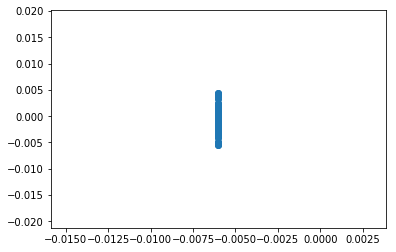

In [199]:
latent_grid = generate_grid(-3, 3, step, latent_size)
true_posterior = compute_true_posterior(tracked_inputs, latent_grid, vae, tracked_targets)
true_mean = compute_true_posterior_mean(true_posterior.t(), latent_grid)
approximate_mean, _, _ = vae(tracked_inputs)
plt.scatter(true_mean.detach().numpy(), approximate_mean.detach().numpy())
plt.show()

In [200]:
print(true_mean)

tensor([[-0.0060],
        [-0.0060],
        [-0.0060],
        [-0.0060],
        [-0.0060],
        [-0.0060],
        [-0.0060],
        [-0.0060],
        [-0.0060],
        [-0.0060],
        [-0.0060],
        [-0.0060],
        [-0.0060],
        [-0.0060],
        [-0.0060],
        [-0.0060],
        [-0.0060],
        [-0.0060],
        [-0.0060],
        [-0.0060],
        [-0.0060],
        [-0.0060],
        [-0.0060],
        [-0.0060],
        [-0.0060],
        [-0.0060],
        [-0.0060],
        [-0.0060],
        [-0.0060],
        [-0.0060],
        [-0.0060],
        [-0.0060],
        [-0.0060],
        [-0.0060],
        [-0.0060],
        [-0.0060],
        [-0.0060],
        [-0.0060],
        [-0.0060],
        [-0.0060],
        [-0.0060],
        [-0.0060],
        [-0.0060],
        [-0.0060],
        [-0.0060],
        [-0.0060],
        [-0.0060],
        [-0.0060],
        [-0.0060],
        [-0.0060],
        [-0.0060],
        [-0.0060],
        [-0.